In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# Data Preparation & Preliminary Analysis
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
data = pd.read_excel(url)

# Basic data analysis
print(data.describe())
print(data.isnull().sum())

# Drop rows with missing customer ID
data = data.dropna(subset=['CustomerID'])

# Remove negative quantities (like returns)
data = data[data['Quantity'] > 0]

# Create a new column for total price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


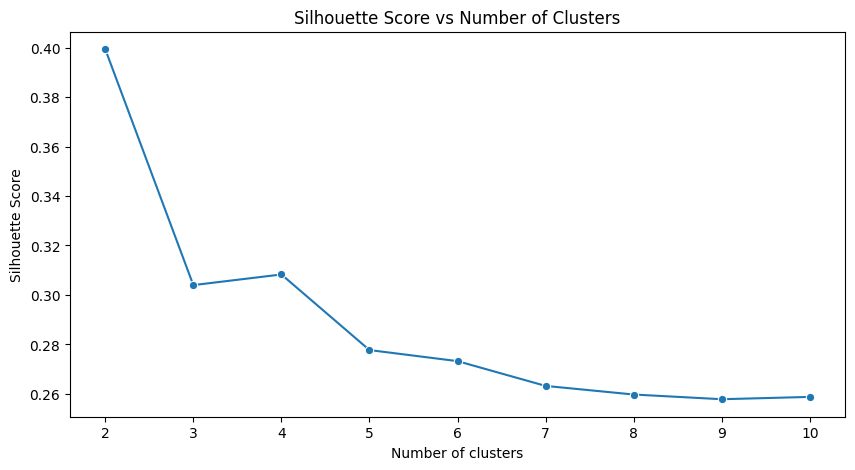

In [ ]:
# Feature Engineering
latest_purchase = data['InvoiceDate'].max() + pd.DateOffset(days=1)

# RFM (Recency, Frequency, Monetary) analysis
rfm = data.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (latest_purchase - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Handle skewness and scale the RFM values
rfm_log = np.log(rfm + 1)  # Adding 1 to handle possible zero values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# 3. Determine the optimal number of clusters
silhouette_scores = []

# Suppressing the warning by setting n_init
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster, n_init=10, random_state=0)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.fit_predict(rfm_scaled)))

plt.figure(figsize=(10,5))
sns.lineplot(x=range(2, 11), y=silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# Choose the number of clusters based on the silhouette plot
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because we started from 2 clusters

# 4. Clustering using KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
clusters = kmeans.fit_predict(rfm_scaled)
rfm['Cluster'] = clusters

print(rfm.head())

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         326          1  77183.60        1
12347.0           2        182   4310.00        0
12348.0          75         31   1797.24        1
12349.0          19         73   1757.55        0
12350.0         310         17    334.40        1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


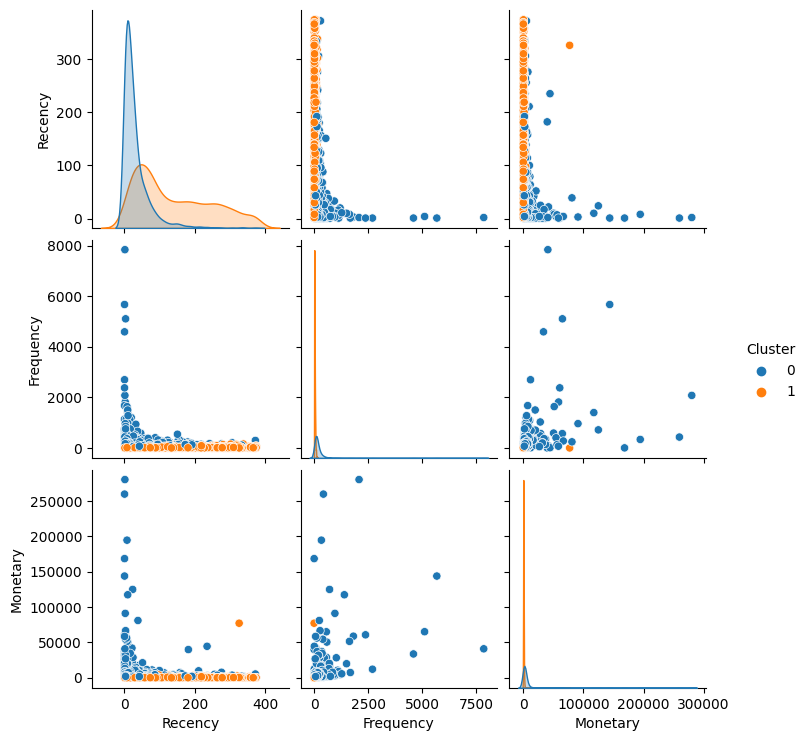

In [ ]:
# Visualizing the clusters using seaborn's pairplot for multi-dimensional data
sns.pairplot(data=rfm, hue='Cluster')

plt.show()

In [ ]:
def getUnexpiredTokens(time_to_live, queries):
    # A dictionary to store token with its expiration time.
    tokens = {}
    result = []

    for query in queries:
        query_parts = query.split()

        # Extracting action type
        action_type = query_parts[0]
        current_time = int(query_parts[-1])

        if action_type == "generate":
            token_id = query_parts[1]
            tokens[token_id] = current_time + time_to_live

        elif action_type == "renew":
            token_id = query_parts[1]
            # Renew the token if it exists and hasn't expired.
            if token_id in tokens and current_time < tokens[token_id]:
                tokens[token_id] = current_time + time_to_live

        elif action_type == "count":
            # Count tokens that haven't expired.
            count = sum(1 for expiration in tokens.values() if current_time < expiration)
            result.append(count)

    return result

if __name__ == '__main__':
    fptr = open(os.environ['OUTPUT_PATH'], 'w')
    time_to_live = int(input().strip())
    queries_count = int(input().strip())
    queries = []
    for _ in range(queries_count):
        queries_item = input()
        queries.append(queries_item)
    result = getUnexpiredTokens(time_to_live, queries)
    fptr.write('\n'.join(map(str, result)))
    fptr.write('\n')
    fptr.close()